# Part 1 - Text Processing
The following cells contain the necessary funtions to clean and prepare the data for the following parts.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import csv
import json
import math
import time
import string
import collections
import numpy as np
from numpy import linalg as la
from collections import defaultdict
from array import array
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Paths of the documents used in this notebook.
docs_path = '/content/drive/MyDrive/fashion_products_dataset.json'
validation_path = '/content/drive/MyDrive/validation_labels.csv'

with open(docs_path, 'r') as fp:
    lines = json.load(fp)

In [ ]:
def build_terms(line):
    """
    Preprocess the text (title + description):
    - Lowercase
    - Remove punctuation and special symbols (e.g., ₹, %, ™)
    - Normalize spaces
    - Tokenization
    - Remove stop words
    - Lemmatization
    - Stemming
    """
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    # Lowercase
    line = line.lower()

    # Remove punctuation and uncommon symbols
    line = re.sub(r"[^\w\s]", " ", line)

    # Normalize spaces
    line = re.sub(r"\s+", " ", line).strip()

    # Tokenize
    tokens = line.split()

    # Remove stop words
    tokens = [w for w in tokens if w not in stop_words]

    # Lemmatization (reduces words to their base form)
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # Stemming (we don't need, explained in the report)
    tokens = [stemmer.stem(w) for w in tokens]

    return tokens


In [ ]:
def create_index(lines):
    """
    Build an inverted index for the product dataset (JSON format).

    Returns:
    index - inverted index (term -> [pid, [positions]])
    products_info - dictionary with all product data (pid -> full document info)
    """
    index = defaultdict(list)
    products_info = {}

    for doc in lines:  # cada doc és un diccionari
        pid = doc.get("pid", "")
        title = doc.get("title", "")
        description = doc.get("description", "")
        brand = doc.get("brand", "")
        category = doc.get("category", "")
        sub_category = doc.get("sub_category", "")
        product_details = doc.get("product_details", "")
        seller = doc.get("seller", "")
        out_of_stock = doc.get("out_of_stock", "")
        selling_price_str = doc.get("selling_price", "").replace(',', '')
        selling_price = float(selling_price_str) if selling_price_str else 0.0 # Empty field as 0
        discount_str = doc.get("discount", "").strip('% off')
        discount = float(discount_str) if discount_str else 0.0 # Empty field as 0
        actual_price_str = doc.get("actual_price", "").replace(',', '')
        actual_price = float(actual_price_str) if actual_price_str else 0.0 # Empty field as 0
        average_rating_str = doc.get("average_rating", "")
        average_rating = float(average_rating_str) if average_rating_str else None # Empty field as None
        url = doc.get("url", "")

        # combine title and description for indexing
        text = f"{title} {description}"
        terms = build_terms(text)

        # store complete product info
        products_info[pid] = {
            "pid": pid,
            "title": title,
            "description": description,
            "brand": brand,
            "category": category,
            "sub_category": sub_category,
            "product_details": product_details,
            "seller": seller,
            "out_of_stock": out_of_stock,
            "selling_price": selling_price,
            "discount": discount,
            "actual_price": actual_price,
            "average_rating": average_rating,
            "url": url
        }

        # create current page index
        current_page_index = {}
        for position, term in enumerate(terms):
            try:
                current_page_index[term][1].append(position)
            except:
                current_page_index[term] = [pid, array('I', [position])]

        # merge with main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

    return index, products_info

In [ ]:
start_time = time.time()
index, products_info = create_index(lines)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 38.37 seconds


In [ ]:
def search(query, index, products_info):
    """
    Search for a query in the inverted index.
    Returns a list of product dictionaries (with all fields) that match any of the query terms.
    """
    query_terms = build_terms(query)  # Normalize and apply the same pre-processment
    matching_pids = set()

    for term in query_terms:
        try:
            #We obtain the PIDs that contain the term.
            term_pids = [posting[0] for posting in index[term]]
            matching_pids |= set(term_pids)  # unió
        except KeyError:
            # If already in the dictionary, ingnore it
            pass

    # Return all the found products info.
    results = [products_info[pid] for pid in matching_pids if pid in products_info]

    return results


In [ ]:
query = "women full sleeve sweatshirt cotton"
results_q1 = search(query, index, products_info)

query_2 = "men slim jeans blue"
results_q2 = search(query_2, index, products_info)


top = 10
print("\n======================")
print(f"Sample of {top} results out of {len(results_q1)} for the searched query:\n")

for product in results_q1[:top]:
    print(f"PID: {product['pid']}")
    print(f"Title: {product['title']}")
    print(f"Brand: {product['brand']}")
    print(f"Category: {product['category']}")
    print(f"Sub-category: {product['sub_category']}")
    print(f"Selling Price: {product['selling_price']}")
    print(f"Discount: {product['discount']}")
    print(f"Average Rating: {product['average_rating']}")
    print(f"URL: {product['url']}\n")



Sample of 10 results out of 19471 for the searched query:

PID: SHTFRR7FFJVZXMHN
Title: Women Slim Fit Checkered Cut Away Collar Casual Shirt
Brand: ECKO Unl
Category: Clothing and Accessories
Sub-category: Topwear
Selling Price: 734.0
Discount: 30.0
Average Rating: 2.5
URL: https://www.flipkart.com/ecko-unltd-men-checkered-casual-green-shirt/p/itmbd4ee13a991c8?pid=SHTFRR7FFJVZXMHN&lid=LSTSHTFRR7FFJVZXMHNMP9QRT&marketplace=FLIPKART&srno=b_20_774&otracker=browse&fm=organic&iid=79495f27-83b2-41dc-8c9f-8c5ebbf994af.SHTFRR7FFJVZXMHN.SEARCH&ssid=64io9e0ezk0000001612104166861

PID: TSHFWYCTGYMG6VPM
Title: Solid Women V Neck Yellow T-Shirt
Brand: NEXT 
Category: Clothing and Accessories
Sub-category: Topwear
Selling Price: 379.0
Discount: 62.0
Average Rating: 3.8
URL: https://www.flipkart.com/next-solid-men-v-neck-yellow-t-shirt/p/itm01e59cacc5c90?pid=TSHFWYCTGYMG6VPM&lid=LSTTSHFWYCTGYMG6VPMEZZSAM&marketplace=FLIPKART&srno=b_1_18&otracker=browse&fm=organic&iid=2af509a1-0b5c-42d7-b033-e46bb3b

In [ ]:
validation_data = []

with open(validation_path, newline='', encoding='utf-8') as csvfile:
    lector = csv.reader(csvfile)
    for fila in lector:
        validation_data.append(fila)



products_label1_rel = [row[1] for row in validation_data if (row[2] == '1' and row[3] == '1')]  # PIDs with label 1 that are relevant
products_label2_rel = [row[1] for row in validation_data if (row[2] == '2' and row[3] == '1')]  # PIDs with label 0 that are relevant

set_label1_rel = set(products_label1_rel)
set_label2_rel = set(products_label2_rel)

pids_q1 = set(r['pid'] for r in results_q1) #PIDs of the retrieved ones from search()
pids_q2 = set(r['pid'] for r in results_q2)

correct_q1 = set_label1_rel & pids_q1 # products that coincide between the ones we have and the relevant ones from csv.
correct_q2 = set_label2_rel & pids_q2

coverage_q1 = (len(correct_q1) / len(set_label1_rel)) * 100
coverage_q2 = (len(correct_q2) / len(set_label2_rel)) * 100

print(f"Query 1: '{query}'")
print(f" - Relevant products (label 1): {len(set_label1_rel)}")
print(f" - Coverage: {coverage_q1:.2f}%")

print(f"\nQuery 2: '{query_2}'")
print(f" - Relevant products (label 2): {len(set_label2_rel)}")
print(f" - Coverage: {coverage_q2:.2f}%")


Query 1: 'women full sleeve sweatshirt cotton'
 - Relevant products (label 1): 13
 - Coverage: 100.00%

Query 2: 'men slim jeans blue'
 - Relevant products (label 2): 10
 - Coverage: 100.00%


In [ ]:
df = pd.DataFrame(products_info)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (14, 28080)


,TKPFCZ9EA7H5FYZH,TKPFCZ9EJZV2UVRZ,TKPFCZ9EHFCY5Z4Y,TKPFCZ9ESZZ7YWEF,TKPFCZ9EVXKBSUD7,TKPFCZ9EFK9DNWDA,TKPFDABN3GXYPFHE,TKPFCZ9ESGZYT8NH,TKPFCZ9DYU33FFXS,TKPFDABN4NQFVKZY,...,SRTFTD8JGQDAQ5AF,SRTFTD8JWG6DPXKZ,SRTFJ7PNS8Y6XMSY,TSHFWNWF6XZZBEGW,DHYFHFUKFFJSPC98,JCKFYPM35WMMTAEN,SRTFV8S7DCEWAQVH,BZRFNAH7NWUB6F5E,JCKFWZZM6V7RS5EA,JCKFWTPCWNQSFAH3
pid,TKPFCZ9EA7H5FYZH,TKPFCZ9EJZV2UVRZ,TKPFCZ9EHFCY5Z4Y,TKPFCZ9ESZZ7YWEF,TKPFCZ9EVXKBSUD7,TKPFCZ9EFK9DNWDA,TKPFDABN3GXYPFHE,TKPFCZ9ESGZYT8NH,TKPFCZ9DYU33FFXS,TKPFDABN4NQFVKZY,...,SRTFTD8JGQDAQ5AF,SRTFTD8JWG6DPXKZ,SRTFJ7PNS8Y6XMSY,TSHFWNWF6XZZBEGW,DHYFHFUKFFJSPC98,JCKFYPM35WMMTAEN,SRTFV8S7DCEWAQVH,BZRFNAH7NWUB6F5E,JCKFWZZM6V7RS5EA,JCKFWTPCWNQSFAH3
title,Solid Women Multicolor Track Pants,Solid Men Blue Track Pants,Solid Men Multicolor Track Pants,Solid Women Multicolor Track Pants,"Solid Women Brown, Grey Track Pants",Solid Women Multicolor Track Pants,Solid Women Dark Blue Track Pants,Solid Women Beige Track Pants,Solid Women Black Track Pants,Solid Men Grey Track Pants,...,Solid Men Grey Bermuda Shorts,Solid Women Grey Bermuda Shorts,Solid Women Black Night Shorts,Solid Men Round Neck Pink T-Shirt,Checkered Men Multicolor Regular Shorts,Sleeveless Solid Men Jacket,Printed Men Blue Regular Shorts,Checkered Single Breasted Casual Women Full Sl...,Full Sleeve Solid Men Casual Jacket,Full Sleeve Solid Women Casual Jacket
description,Yorker trackpants made from 100% rich combed c...,Yorker trackpants made from 100% rich combed c...,Yorker trackpants made from 100% rich combed c...,Yorker trackpants made from 100% rich combed c...,Yorker trackpants made from 100% rich combed c...,Yorker trackpants made from 100% rich combed c...,Yorker trackpants made from 100% rich combed c...,Yorker trackpants made from 100% rich combed c...,Yorker trackpants made from 100% rich combed c...,Yorker trackpants made from 100% rich combed c...,...,‘OKANE’ endeavors to continue to be a leader i...,‘OKANE’ endeavors to continue to be a leader i...,‘OKANE’ endeavors to continue to be a leader i...,,,,,,,‘OKANE’ endeavors to continue to be a leader i...
brand,York,York,York,York,York,York,York,York,York,York,...,Oka,Oka,Oka,Oka,Oka,Oka,Oka,Oka,Oka,Oka
category,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,...,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories,Clothing and Accessories


# Part 2 - Exploratory Data Analysis
In the following code cells, we have applied some EDA techinques and methods to obtain an overview of our data, some relations and distributions it may have.

In [ ]:
# Basic info
df.info()

# Missing values
print("\nMissing values per column:")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, pid to url
Columns: 28080 entries, TKPFCZ9EA7H5FYZH to JCKFWTPCWNQSFAH3
dtypes: object(28080)
memory usage: 3.0+ MB

Missing values per column:
TKPFCZ9EA7H5FYZH    0
TKPFCZ9EJZV2UVRZ    0
TKPFCZ9EHFCY5Z4Y    0
TKPFCZ9ESZZ7YWEF    0
TKPFCZ9EVXKBSUD7    0
                   ..
JCKFYPM35WMMTAEN    1
SRTFV8S7DCEWAQVH    0
BZRFNAH7NWUB6F5E    1
JCKFWZZM6V7RS5EA    0
JCKFWTPCWNQSFAH3    1
Length: 28080, dtype: int64


Dataset shape: (28080, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28080 entries, 0 to 28079
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pid              28080 non-null  object 
 1   title            28080 non-null  object 
 2   description      28080 non-null  object 
 3   brand            28080 non-null  object 
 4   category         28080 non-null  object 
 5   sub_category     28080 non-null  object 
 6   product_details  28080 non-null  object 
 7   seller           28080 non-null  object 
 8   out_of_stock     28080 non-null  bool   
 9   selling_price    28080 non-null  float64
 10  discount         28080 non-null  float64
 11  actual_price     28080 non-null  float64
 12  average_rating   25819 non-null  float64
 13  url              28080 non-null  object 
dtypes: bool(1), float64(4), object(9)
memory usage: 2.8+ MB

✅ Cleaned numeric columns and summary statistics:
       selling_p

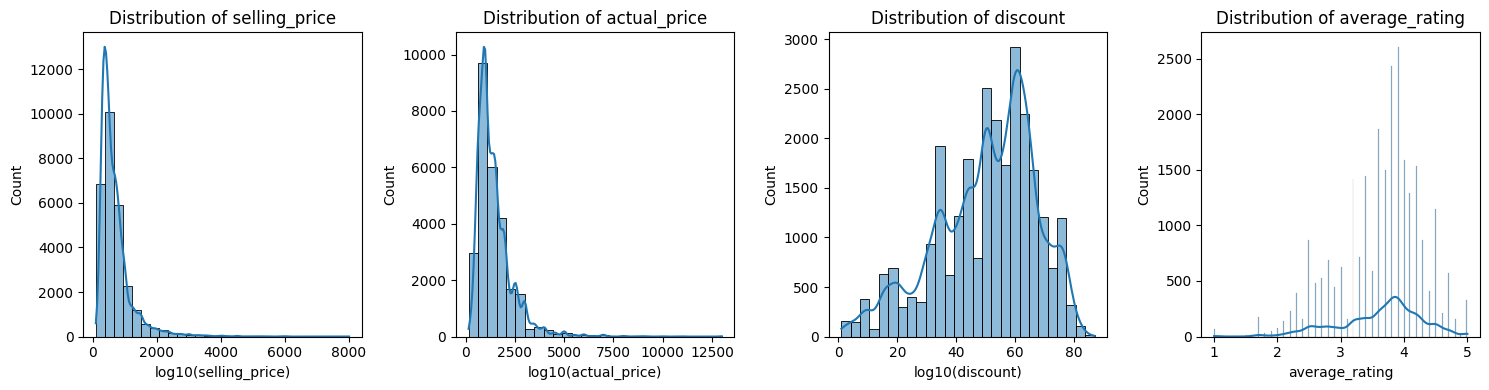

In [ ]:
# Create a list of dictionaries from products_info values
products_list = list(products_info.values())

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(products_list)

print("Dataset shape:", df.shape)
df.head()
df.info()

# Columns to clean and visualize
numeric_cols = ["selling_price", "actual_price", "discount", "average_rating"]


print("\n✅ Cleaned numeric columns and summary statistics:")
print(df[numeric_cols].describe())
df['description_length'] = df['description'].apply(len)

print("\nDataset shape after adding 'description_length' column:", df.shape)

# Plot histograms with log scale
plt.figure(figsize=(15, 4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 4, i)
    data = df[col].dropna()

    # Apply log scale only for price and discount
    if col in ["selling_price", "actual_price", "discount"]:
        # Handle potential zero or negative values before applying log scale
        data = data[data > 0]
        if not data.empty:
             sns.histplot((data), kde=True, bins=int(len(data)/1000)) # Use log10 for better visualization
             plt.xlabel(f'log10({col})')
        else:
            plt.title(f'{col} (No data > 0)')

    else:
        sns.histplot(data, kde=True, bins=int(len(data)/100))
        plt.xlabel(col)

    plt.title(f'Distribution of {col}')


plt.tight_layout()
plt.show()

In [ ]:
print("Average Sentence Length:", df['description_length'].mean().round(2))

Average Sentence Length: 175.95


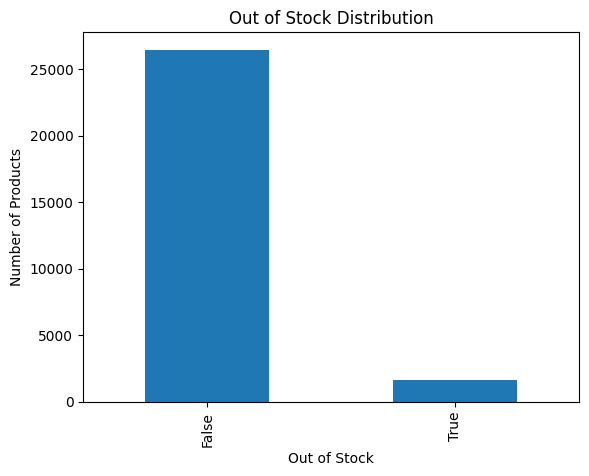

In [ ]:
df["out_of_stock"].value_counts().plot(kind="bar")
plt.title("Out of Stock Distribution")
plt.xlabel("Out of Stock")
plt.ylabel("Number of Products")
plt.show()

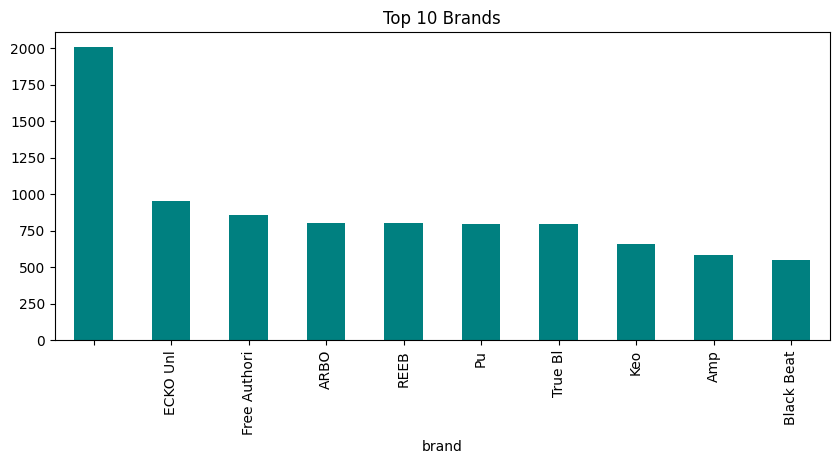

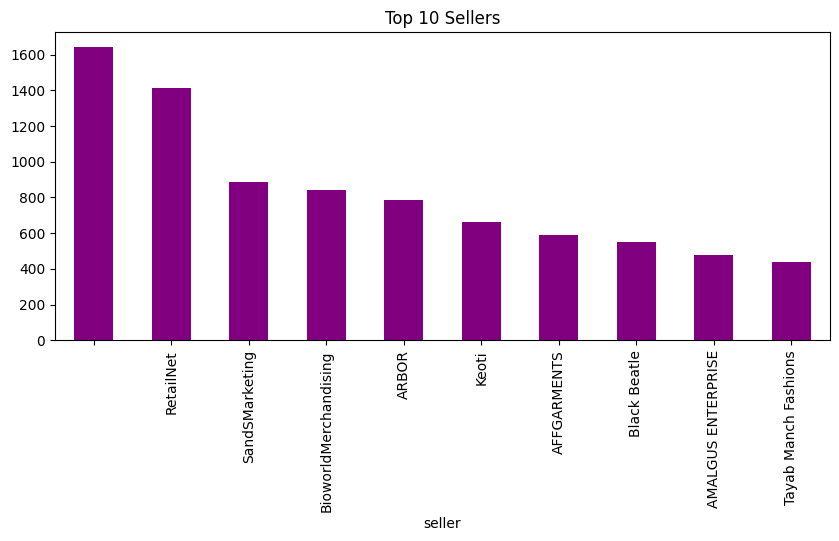

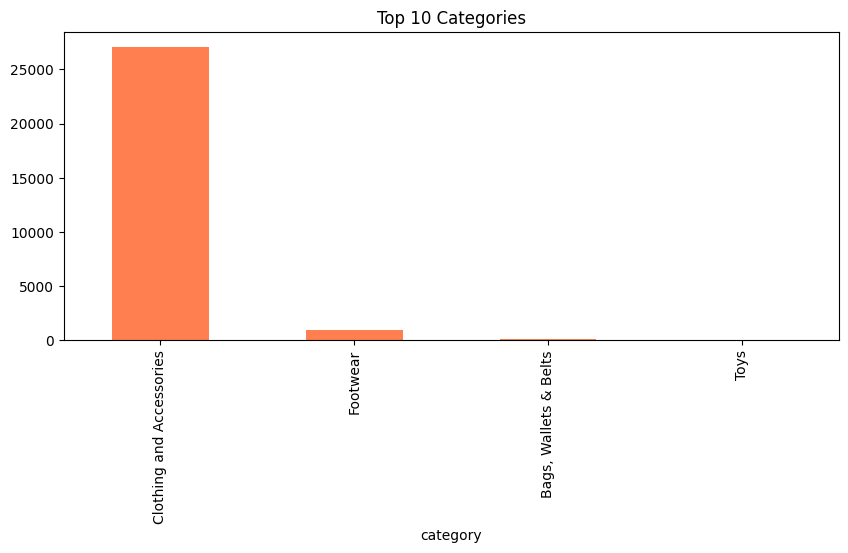

In [ ]:
top_brands = df["brand"].value_counts().head(10)
top_brands.plot(kind="bar", figsize=(10, 4), color="teal", title="Top 10 Brands")
plt.show()

top_sellers = df["seller"].value_counts().head(10)
top_sellers.plot(kind="bar", figsize=(10, 4), color="purple", title="Top 10 Sellers")
plt.show()

top_cats = df["category"].value_counts().head(10)
top_cats.plot(kind="bar", figsize=(10, 4), color="coral", title="Top 10 Categories")
plt.show()

Total tokens: 683332
Unique vocabulary size: 5998


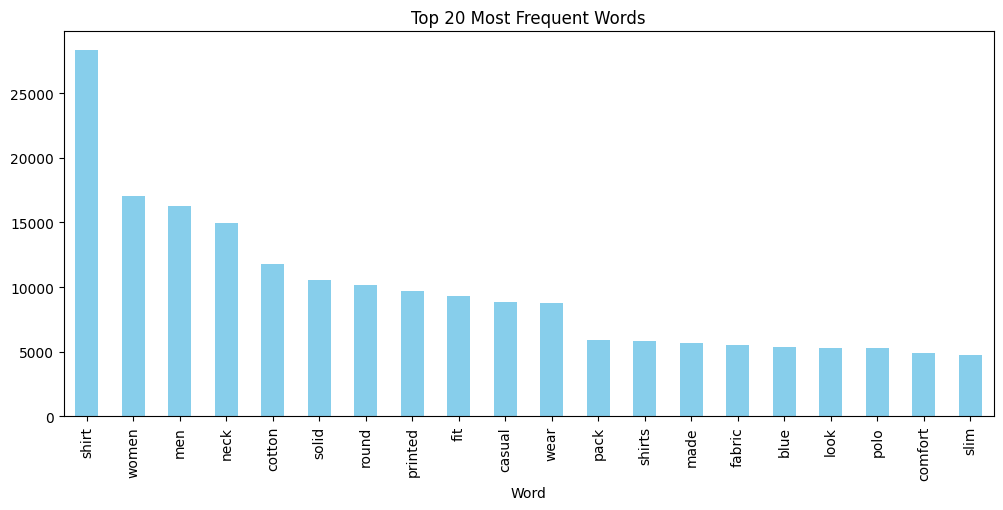

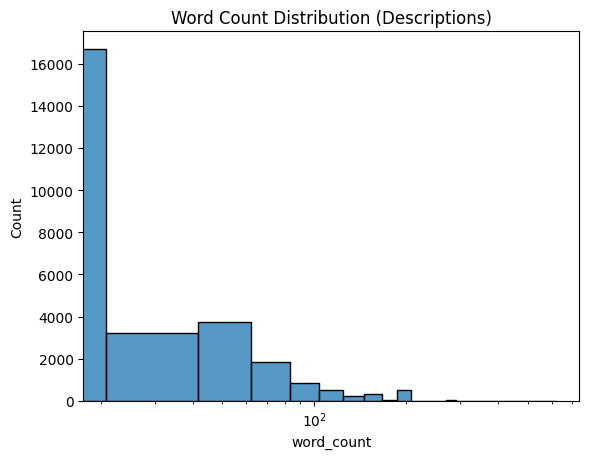

In [ ]:
# Combine title + description for analysis
texts = (df["title"].fillna('') + " " + df["description"].fillna('')).tolist()

# Tokenize
stop_words = set(stopwords.words("english"))
tokens = []
for t in texts:
    t = re.sub(r"[^a-zA-Z\s]", " ", t.lower())
    tokens.extend([w for w in t.split() if w not in stop_words and len(w) > 2])

word_counts = Counter(tokens)
print("Total tokens:", len(tokens))
print("Unique vocabulary size:", len(word_counts))

# --- Top 20 most common words
pd.DataFrame(word_counts.most_common(20), columns=["Word", "Count"]).set_index("Word").plot(
    kind="bar", figsize=(12, 5), color="skyblue", legend=False, title="Top 20 Most Frequent Words"
)
plt.show()

# --- Word count per product
df["word_count"] = df["description"].fillna("").apply(lambda x: len(x.split()))
sns.histplot(df["word_count"], bins=30)
plt.xscale("log")
plt.title("Word Count Distribution (Descriptions)")
plt.show()

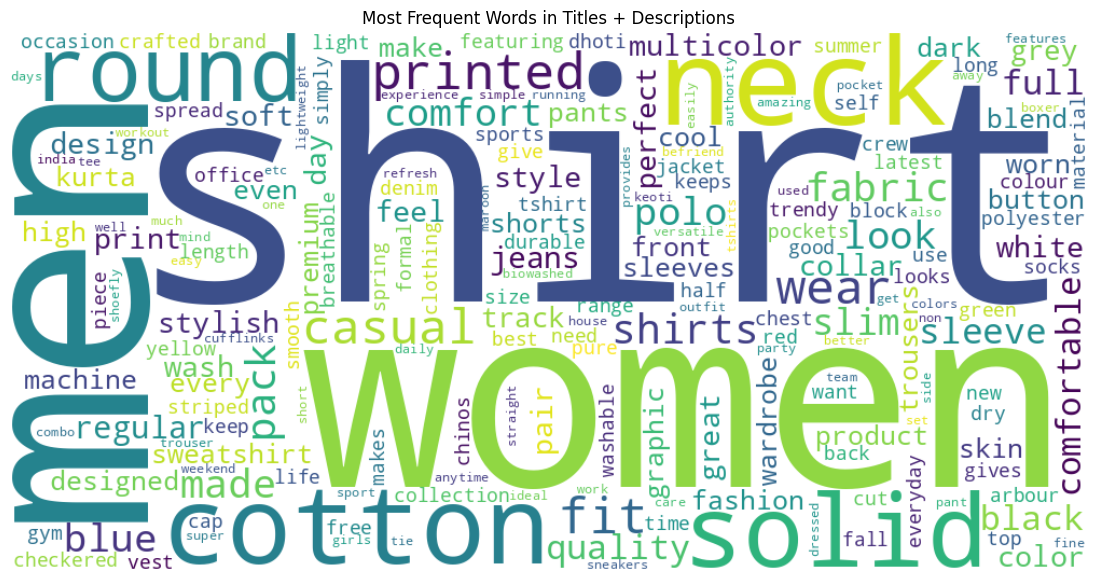

In [ ]:
# Generate Word Cloud for overall frequent words
wc = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(word_counts)
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Titles + Descriptions")
plt.show()